In [1]:
import os
os.chdir('..')

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# Modelling and Finetuning
import optuna
import lightgbm as lgb
# Metrics
from sklearn.metrics import (root_mean_squared_log_error,
                             mean_squared_error,
                             mean_absolute_error, 
                             r2_score)
# Saving Model
import joblib
# Explanations
import shap

In [3]:
# Importing
data = pd.read_csv('data/IR_raw_data.csv')

In [4]:
data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [5]:
# General Info on data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [6]:
# TARGET COLUMN
target_col = "Premium Amount"

cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(exclude=['object']).columns

In [7]:
# Descriptive statistics
data.describe().round(2)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.00,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000.00
mean,599999.50,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,1102.54
std,346410.31,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,865.00
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00
25%,299999.75,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,514.00
50%,599999.50,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00
75%,899999.25,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,1509.00
max,1199999.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00


In [8]:
# Checking for number of unique categories amongst the categorical variables
for col in cat_cols:
    num_unique = data[col].nunique()
    print(f"'{col}' has {num_unique} unique categories")

'Gender' has 2 unique categories
'Marital Status' has 3 unique categories
'Education Level' has 4 unique categories
'Occupation' has 3 unique categories
'Location' has 3 unique categories
'Policy Type' has 3 unique categories
'Policy Start Date' has 167381 unique categories
'Customer Feedback' has 3 unique categories
'Smoking Status' has 2 unique categories
'Exercise Frequency' has 4 unique categories
'Property Type' has 3 unique categories


In [9]:
# Distribution of categories within the categorical variables
for col in cat_cols:
    print(f"Top value counts in {col}: \n {data[col].value_counts().head(10)}")

Top value counts in Gender: 
 Gender
Male      602571
Female    597429
Name: count, dtype: int64
Top value counts in Marital Status: 
 Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64
Top value counts in Education Level: 
 Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64
Top value counts in Occupation: 
 Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64
Top value counts in Location: 
 Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64
Top value counts in Policy Type: 
 Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64
Top value counts in Policy Start Date: 
 Policy Start Date
2020-02-08 15:21:39.134960    142
2023-08-13 15:21:39.155231    137
2022-02-02 15:21:39.134960    137
2022-08-30 15:21:39.13496

In [10]:
# Mean, Standard Deviation and Skewness of the numerical columns
print("The mean of columns:")
print(data[num_cols].mean())

print("\nThe std dev of columns:")
print(data[num_cols].std())

print("\nThe skewness of columns:")
print(data[num_cols].skew())

The mean of columns:
id                      599999.500000
Age                         41.145563
Annual Income            32745.217777
Number of Dependents         2.009934
Health Score                25.613908
Previous Claims              1.002689
Vehicle Age                  9.569889
Credit Score               592.924350
Insurance Duration           5.018219
Premium Amount            1102.544822
dtype: float64

The std dev of columns:
id                      346410.305851
Age                         13.539950
Annual Income            32179.506124
Number of Dependents         1.417338
Health Score                12.203462
Previous Claims              0.982840
Vehicle Age                  5.776189
Credit Score               149.981945
Insurance Duration           2.594331
Premium Amount             864.998859
dtype: float64

The skewness of columns:
id                      3.836279e-16
Age                    -1.253192e-02
Annual Income           1.470357e+00
Number of Dependents   -1.3

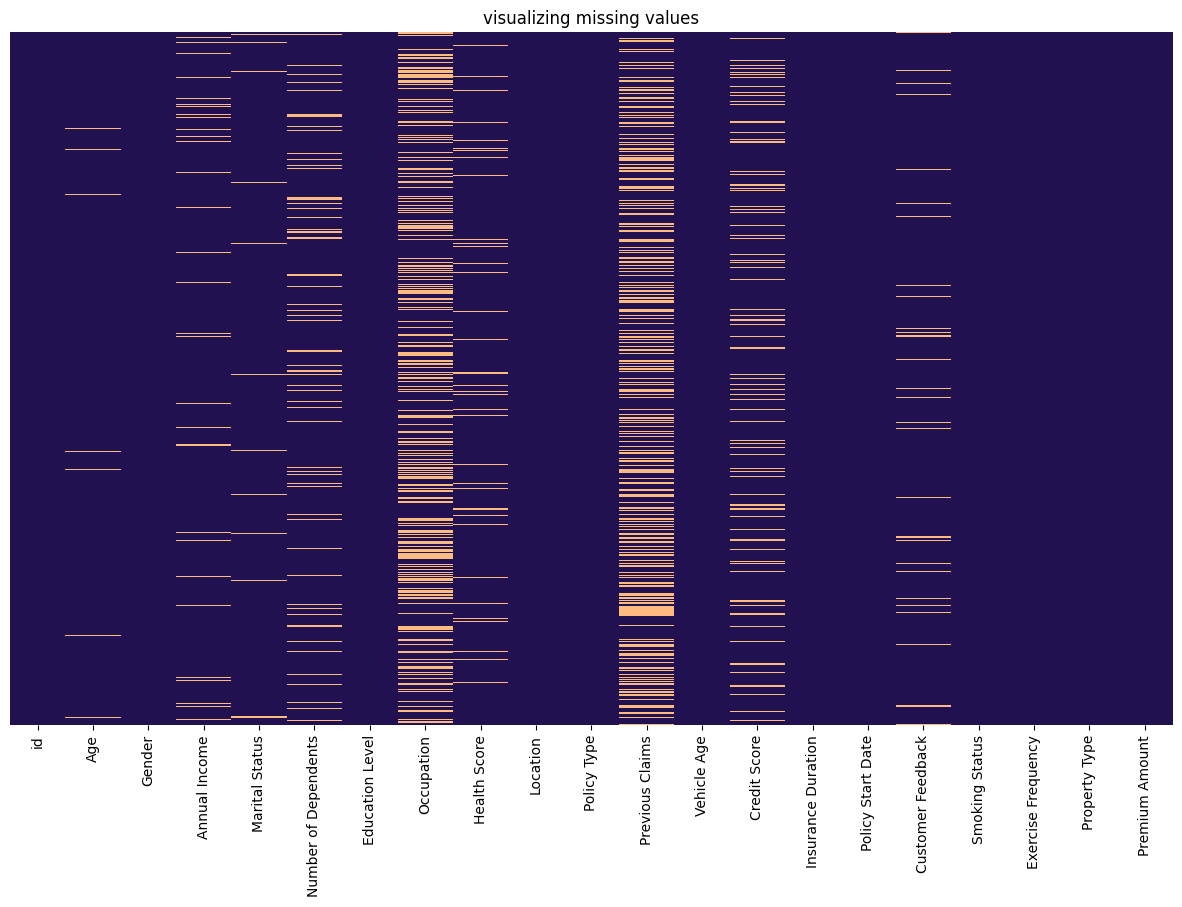

In [11]:
# Visualizing the null values in the dataframe
plt.figure(figsize=(15,9))
plt.title("visualizing missing values")
sns.heatmap(data.isnull(), cbar = False, cmap = sns.color_palette('magma'), yticklabels=False)
plt.show()

In [12]:
# SPlits
train_data, test_data = train_test_split(data, test_size = 0.35, random_state = 42)

In [13]:

def date(df):
    """creates additional features from the date column

    Args:
        df (Dataframe): input dataframe containing the date column

    Returns:
       Dataframe: dataframe with added features
    """
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

# Apply the date function to both datasets
train_data = date(train_data)
test_data = date(test_data)

In [14]:
# Split train data into features and target
X = train_data.drop(columns=[target_col, 'id', 'Group', 'Year', 'Month', 'Day', 'Week'])
y = train_data[target_col]
y_test = test_data[target_col]
X_test = test_data.drop(columns=['id', 'Group', 'Year', 'Month', 'Day', 'Week'])

In [15]:
# separate numeric and categorical features
numerical_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

In [42]:
categorical_features

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type', 'Month_name', 'Day_of_week'],
      dtype='object')

In [16]:
# Treat Null values
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing values 
    #('scaler', StandardScaler())     # Scale numerical features
])

# Preprocessing pipeline for categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # Encode categorical features
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

# Preprocess train and test data
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(X_test)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
def objective(trial):
    # Define parameter search space
    param = {
    "objective": "regression",
    "metric": "rmse",  
    "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
    "num_leaves": trial.suggest_int("num_leaves", 200, 512),
    "learning_rate": trial.suggest_float("learning_rate", 0.002, 0.1, log=True),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
    "max_depth": trial.suggest_int("max_depth", -1, 16),
    "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),# Lasso
    "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),# Ridge
    "device_type": "gpu",
    "deterministic": True,
    "seed": 42,}


    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute RMSLE using sklearn's root_mean_squared_log_error
    rmsle = root_mean_squared_log_error(y_val, np.maximum(y_val_pred, 0))
    return rmsle

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-29 11:24:55,912] A new study created in memory with name: no-name-f6ba0fdd-4154-45c1-b1ee-382b6cb99e30


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.038070 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:24:59,970] Trial 0 finished with value: 1.141912263920061 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'learning_rate': 0.02881022862164231, 'feature_fraction': 0.64026910531765, 'bagging_fraction': 0.6738466252966158, 'bagging_freq': 11, 'min_data_in_leaf': 83, 'max_depth': 8, 'lambda_l1': 1.6816711076316315, 'lambda_l2': 0.000947864977684805}. Best is trial 0 with value: 1.141912263920061.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.035255 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Si

[I 2025-07-29 11:25:04,259] Trial 1 finished with value: 1.1571329402545465 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 286, 'learning_rate': 0.004295381193841267, 'feature_fraction': 0.9496204495805136, 'bagging_fraction': 0.8159140491603224, 'bagging_freq': 5, 'min_data_in_leaf': 72, 'max_depth': 8, 'lambda_l1': 0.12525558019813218, 'lambda_l2': 9.122815864661607}. Best is trial 0 with value: 1.141912263920061.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.018745 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:25:06,410] Trial 2 finished with value: 1.1658028497620454 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 394, 'learning_rate': 0.0032379556036722175, 'feature_fraction': 0.6032009910665956, 'bagging_fraction': 0.9528219927783941, 'bagging_freq': 8, 'min_data_in_leaf': 54, 'max_depth': 4, 'lambda_l1': 0.19249145971524023, 'lambda_l2': 9.269706137991689}. Best is trial 0 with value: 1.141912263920061.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.015790 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:25:11,569] Trial 3 finished with value: 1.1613651278025654 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 262, 'learning_rate': 0.0030751380053894058, 'feature_fraction': 0.723034977865332, 'bagging_fraction': 0.6737546273007782, 'bagging_freq': 5, 'min_data_in_leaf': 43, 'max_depth': 14, 'lambda_l1': 0.01833395739707459, 'lambda_l2': 0.000277478366385962}. Best is trial 0 with value: 1.141912263920061.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036179 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:25:17,092] Trial 4 finished with value: 1.133253171497133 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 352, 'learning_rate': 0.05313960472505183, 'feature_fraction': 0.6638099625911728, 'bagging_fraction': 0.6368831839665904, 'bagging_freq': 6, 'min_data_in_leaf': 43, 'max_depth': 15, 'lambda_l1': 0.3622171186214774, 'lambda_l2': 0.0005885528895835176}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037923 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.

[I 2025-07-29 11:25:23,561] Trial 5 finished with value: 1.162766380805065 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 350, 'learning_rate': 0.0021122853728981765, 'feature_fraction': 0.7695213926375946, 'bagging_fraction': 0.984567261949906, 'bagging_freq': 10, 'min_data_in_leaf': 80, 'max_depth': -1, 'lambda_l1': 0.284668461862262, 'lambda_l2': 0.0007263240217578425}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016065 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.

[I 2025-07-29 11:25:25,651] Trial 6 finished with value: 1.1634083197233331 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 407, 'learning_rate': 0.0036119415063245765, 'feature_fraction': 0.9587105728441199, 'bagging_fraction': 0.8664519265421146, 'bagging_freq': 11, 'min_data_in_leaf': 71, 'max_depth': 5, 'lambda_l1': 0.00811019079759361, 'lambda_l2': 0.006367542864455357}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Info] 26 dense feature groups (14.44 MB) transferred to GPU in 0.023159 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036010 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results

[I 2025-07-29 11:25:30,198] Trial 7 finished with value: 1.1422004208985188 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.017180095754997883, 'feature_fraction': 0.7355342342625819, 'bagging_fraction': 0.8956378448517681, 'bagging_freq': 12, 'min_data_in_leaf': 41, 'max_depth': 14, 'lambda_l1': 0.0021594200408177455, 'lambda_l2': 0.00013757180036818643}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.035602 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:25:31,863] Trial 8 finished with value: 1.1660846241341256 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'learning_rate': 0.006515442323693676, 'feature_fraction': 0.6974089533468086, 'bagging_fraction': 0.7448870192338486, 'bagging_freq': 7, 'min_data_in_leaf': 62, 'max_depth': 3, 'lambda_l1': 0.3755593713427542, 'lambda_l2': 0.010411867015178038}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.40 MB) transferred to GPU in 0.012618 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[

[I 2025-07-29 11:25:38,505] Trial 9 finished with value: 1.14704596799139 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 439, 'learning_rate': 0.01224523884509166, 'feature_fraction': 0.7519703702313641, 'bagging_fraction': 0.7529407923597763, 'bagging_freq': 7, 'min_data_in_leaf': 49, 'max_depth': 16, 'lambda_l1': 0.0019409341665496019, 'lambda_l2': 0.012377879599277566}. Best is trial 4 with value: 1.133253171497133.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037416 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:25:44,864] Trial 10 finished with value: 1.1311993081742675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 495, 'learning_rate': 0.0951014294728968, 'feature_fraction': 0.8617261164348184, 'bagging_fraction': 0.6128173703218938, 'bagging_freq': 6, 'min_data_in_leaf': 21, 'max_depth': 11, 'lambda_l1': 0.00010000363826606021, 'lambda_l2': 0.34389834372727535}. Best is trial 10 with value: 1.1311993081742675.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.015926 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:25:51,083] Trial 11 finished with value: 1.1316335124186974 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 477, 'learning_rate': 0.09121565077222474, 'feature_fraction': 0.8696129001505071, 'bagging_fraction': 0.6070602111907526, 'bagging_freq': 6, 'min_data_in_leaf': 21, 'max_depth': 12, 'lambda_l1': 0.00024395552531239923, 'lambda_l2': 0.291902224540695}. Best is trial 10 with value: 1.1311993081742675.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.035902 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:25:57,409] Trial 12 finished with value: 1.1311176014814008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 495, 'learning_rate': 0.08878670530869029, 'feature_fraction': 0.8594189547947495, 'bagging_fraction': 0.6040276980622258, 'bagging_freq': 9, 'min_data_in_leaf': 20, 'max_depth': 11, 'lambda_l1': 0.00013883906098883698, 'lambda_l2': 0.45421750255717075}. Best is trial 12 with value: 1.1311176014814008.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037332 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:26:03,995] Trial 13 finished with value: 1.130441245275758 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 497, 'learning_rate': 0.06975851734075844, 'feature_fraction': 0.8452321240948053, 'bagging_fraction': 0.7078627257636034, 'bagging_freq': 9, 'min_data_in_leaf': 21, 'max_depth': 11, 'lambda_l1': 0.00011010011488177005, 'lambda_l2': 0.3226517430738078}. Best is trial 13 with value: 1.130441245275758.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016474 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:26:10,626] Trial 14 finished with value: 1.1309688553299797 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 510, 'learning_rate': 0.044468609806571406, 'feature_fraction': 0.8414987047399766, 'bagging_fraction': 0.7356298130077287, 'bagging_freq': 9, 'min_data_in_leaf': 29, 'max_depth': 11, 'lambda_l1': 0.0004934587085474113, 'lambda_l2': 0.4396840516507676}. Best is trial 13 with value: 1.130441245275758.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037568 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:26:15,934] Trial 15 finished with value: 1.132900417579997 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 449, 'learning_rate': 0.04020464887709396, 'feature_fraction': 0.8131980739627942, 'bagging_fraction': 0.7335145841359383, 'bagging_freq': 9, 'min_data_in_leaf': 32, 'max_depth': 9, 'lambda_l1': 0.0006426801037007744, 'lambda_l2': 1.427847305125426}. Best is trial 13 with value: 1.130441245275758.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037153 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (13.

[I 2025-07-29 11:26:18,426] Trial 16 finished with value: 1.1488175552517905 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 451, 'learning_rate': 0.021658863617117382, 'feature_fraction': 0.9083972228479795, 'bagging_fraction': 0.8001078844889955, 'bagging_freq': 10, 'min_data_in_leaf': 32, 'max_depth': 6, 'lambda_l1': 0.0008588194553092544, 'lambda_l2': 0.06413393953230916}. Best is trial 13 with value: 1.130441245275758.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016416 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:26:25,513] Trial 17 finished with value: 1.1303987152772756 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 509, 'learning_rate': 0.0543920452417703, 'feature_fraction': 0.8096218324712784, 'bagging_fraction': 0.6853108150715229, 'bagging_freq': 8, 'min_data_in_leaf': 99, 'max_depth': 12, 'lambda_l1': 0.0047373775768221075, 'lambda_l2': 0.0883038311044315}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036438 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:26:30,703] Trial 18 finished with value: 1.1305698238731008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 311, 'learning_rate': 0.060603006496895664, 'feature_fraction': 0.8069859201714962, 'bagging_fraction': 0.6858467230965506, 'bagging_freq': 8, 'min_data_in_leaf': 96, 'max_depth': 13, 'lambda_l1': 9.054755077687611, 'lambda_l2': 0.06736616287163877}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.035187 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:26:36,565] Trial 19 finished with value: 1.1316135244573315 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 393, 'learning_rate': 0.030146432807505185, 'feature_fraction': 0.9158773227966932, 'bagging_fraction': 0.7021182914224504, 'bagging_freq': 8, 'min_data_in_leaf': 99, 'max_depth': 10, 'lambda_l1': 0.0058843058538166956, 'lambda_l2': 2.0413694162820386}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.026135 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:26:43,493] Trial 20 finished with value: 1.1482053177706741 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 424, 'learning_rate': 0.010526070471403224, 'feature_fraction': 0.7872783902518629, 'bagging_fraction': 0.7786930866509083, 'bagging_freq': 10, 'min_data_in_leaf': 86, 'max_depth': -1, 'lambda_l1': 0.0349727922359719, 'lambda_l2': 0.06453821475655394}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037047 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:26:48,710] Trial 21 finished with value: 1.1304654204152988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 309, 'learning_rate': 0.06010739385165696, 'feature_fraction': 0.8265074761839898, 'bagging_fraction': 0.6735504797661234, 'bagging_freq': 8, 'min_data_in_leaf': 98, 'max_depth': 13, 'lambda_l1': 1.3326485214842452, 'lambda_l2': 0.04213291956441834}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036856 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:26:53,962] Trial 22 finished with value: 1.130441108223536 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 318, 'learning_rate': 0.06561058441471615, 'feature_fraction': 0.8284411884457469, 'bagging_fraction': 0.647377397467075, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'max_depth': 13, 'lambda_l1': 2.032082774163864, 'lambda_l2': 0.02528523251561775}. Best is trial 17 with value: 1.1303987152772756.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016703 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:26:59,529] Trial 23 finished with value: 1.1300531172760548 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 333, 'learning_rate': 0.06760578780154214, 'feature_fraction': 0.9034281045621013, 'bagging_fraction': 0.6437335885414669, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'max_depth': 16, 'lambda_l1': 0.062084911415860054, 'lambda_l2': 0.003555187197463526}. Best is trial 23 with value: 1.1300531172760548.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016793 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:27:05,007] Trial 24 finished with value: 1.1305314442971401 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 329, 'learning_rate': 0.034636354168806595, 'feature_fraction': 0.8990560277520183, 'bagging_fraction': 0.6396900236029321, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'max_depth': 16, 'lambda_l1': 0.03715457863750791, 'lambda_l2': 0.007592706297752237}. Best is trial 23 with value: 1.1300531172760548.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.040937 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:27:10,905] Trial 25 finished with value: 1.1307330711417 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 371, 'learning_rate': 0.025774282521117405, 'feature_fraction': 0.9844648940086002, 'bagging_fraction': 0.6452414108316117, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'max_depth': 15, 'lambda_l1': 6.127019764731672, 'lambda_l2': 0.002291838253735272}. Best is trial 23 with value: 1.1300531172760548.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037694 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (10.

[I 2025-07-29 11:27:15,950] Trial 26 finished with value: 1.1307133070478919 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 287, 'learning_rate': 0.04505601422255051, 'feature_fraction': 0.8819742095011512, 'bagging_fraction': 0.6464342035628179, 'bagging_freq': 6, 'min_data_in_leaf': 74, 'max_depth': 13, 'lambda_l1': 0.08704987543573309, 'lambda_l2': 0.002605974930499203}. Best is trial 23 with value: 1.1300531172760548.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.017059 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:27:21,871] Trial 27 finished with value: 1.1296357511382593 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 373, 'learning_rate': 0.07348564201128967, 'feature_fraction': 0.9422685437531487, 'bagging_fraction': 0.7095882136618051, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'max_depth': 16, 'lambda_l1': 0.9841043840239508, 'lambda_l2': 0.016306424557557386}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.017651 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (11.

[I 2025-07-29 11:27:27,851] Trial 28 finished with value: 1.1344625207980423 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 372, 'learning_rate': 0.018873180518567872, 'feature_fraction': 0.9463556544103072, 'bagging_fraction': 0.7162167609651957, 'bagging_freq': 8, 'min_data_in_leaf': 78, 'max_depth': 16, 'lambda_l1': 0.012519647672955521, 'lambda_l2': 0.12071415330305428}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.035908 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:27:33,355] Trial 29 finished with value: 1.1296777984642221 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 338, 'learning_rate': 0.08096529561270974, 'feature_fraction': 0.9981434368532921, 'bagging_fraction': 0.7721299159927426, 'bagging_freq': 6, 'min_data_in_leaf': 85, 'max_depth': 15, 'lambda_l1': 1.0481017765055365, 'lambda_l2': 0.002257126735078559}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036493 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (13.

[I 2025-07-29 11:27:38,940] Trial 30 finished with value: 1.1297879974551068 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 333, 'learning_rate': 0.07286433505599954, 'feature_fraction': 0.9986367396374082, 'bagging_fraction': 0.8315925267551533, 'bagging_freq': 5, 'min_data_in_leaf': 85, 'max_depth': 15, 'lambda_l1': 1.0853981062596092, 'lambda_l2': 0.002143244921342725}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037328 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (13.

[I 2025-07-29 11:27:44,782] Trial 31 finished with value: 1.1297450929729074 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 339, 'learning_rate': 0.08117557241666884, 'feature_fraction': 0.9910888290235547, 'bagging_fraction': 0.8352829838632433, 'bagging_freq': 5, 'min_data_in_leaf': 85, 'max_depth': 15, 'lambda_l1': 1.1282014080746674, 'lambda_l2': 0.002073833638589818}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016663 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.

[I 2025-07-29 11:27:49,909] Trial 32 finished with value: 1.129979749282595 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 286, 'learning_rate': 0.07709002034649136, 'feature_fraction': 0.9972681524019306, 'bagging_fraction': 0.8468107685797372, 'bagging_freq': 5, 'min_data_in_leaf': 85, 'max_depth': 15, 'lambda_l1': 1.0149454520412828, 'lambda_l2': 0.0012787910307452061}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.017348 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (13.

[I 2025-07-29 11:27:55,744] Trial 33 finished with value: 1.1300585766439497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 370, 'learning_rate': 0.09439287871925908, 'feature_fraction': 0.9739694611820501, 'bagging_fraction': 0.8260973528783844, 'bagging_freq': 5, 'min_data_in_leaf': 65, 'max_depth': 14, 'lambda_l1': 2.4459673357557468, 'lambda_l2': 0.0014038172332039578}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.038618 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:01,187] Trial 34 finished with value: 1.1303642022109892 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 263, 'learning_rate': 0.03572315989530505, 'feature_fraction': 0.9368378747729142, 'bagging_fraction': 0.9046713054241718, 'bagging_freq': 5, 'min_data_in_leaf': 83, 'max_depth': 15, 'lambda_l1': 0.7094951579209108, 'lambda_l2': 0.00023976331997639763}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.039653 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:28:02,698] Trial 35 finished with value: 1.1632493044934895 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 343, 'learning_rate': 0.04644615389022444, 'feature_fraction': 0.9985130903436584, 'bagging_fraction': 0.777847313254232, 'bagging_freq': 6, 'min_data_in_leaf': 75, 'max_depth': 2, 'lambda_l1': 2.936816496761835, 'lambda_l2': 0.020916765619339514}. Best is trial 27 with value: 1.1296357511382593.


[LightGBM] [Info] 26 dense feature groups (12.97 MB) transferred to GPU in 0.013104 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.98 MB) transferred to GPU in 0.012726 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-07-29 11:28:08,666] Trial 36 finished with value: 1.1295234541365713 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 390, 'learning_rate': 0.07531503115295365, 'feature_fraction': 0.9671609202708096, 'bagging_fraction': 0.8277464165795929, 'bagging_freq': 5, 'min_data_in_leaf': 69, 'max_depth': 14, 'lambda_l1': 0.15178398729317716, 'lambda_l2': 0.0004430788374798897}. Best is trial 36 with value: 1.1295234541365713.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016139 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (12.

[I 2025-07-29 11:28:12,705] Trial 37 finished with value: 1.1497060919983368 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 403, 'learning_rate': 0.008019139124529414, 'feature_fraction': 0.9678051989897077, 'bagging_fraction': 0.7758436755673951, 'bagging_freq': 6, 'min_data_in_leaf': 70, 'max_depth': 8, 'lambda_l1': 0.2011679522278983, 'lambda_l2': 0.0003569741831304404}. Best is trial 36 with value: 1.1295234541365713.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.018238 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.

[I 2025-07-29 11:28:18,999] Trial 38 finished with value: 1.1294933155691642 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 384, 'learning_rate': 0.052172936406607355, 'feature_fraction': 0.9326275410372452, 'bagging_fraction': 0.8841486353227405, 'bagging_freq': 5, 'min_data_in_leaf': 58, 'max_depth': 14, 'lambda_l1': 0.546207076145187, 'lambda_l2': 0.000566259371207769}. Best is trial 38 with value: 1.1294933155691642.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.038519 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:25,537] Trial 39 finished with value: 1.1295920156371153 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 391, 'learning_rate': 0.052588823669441, 'feature_fraction': 0.9217311597109248, 'bagging_fraction': 0.9130900385185843, 'bagging_freq': 5, 'min_data_in_leaf': 67, 'max_depth': 14, 'lambda_l1': 0.47333987692357093, 'lambda_l2': 0.0005852340690471092}. Best is trial 38 with value: 1.1294933155691642.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016472 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:31,166] Trial 40 finished with value: 1.1321467894141803 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 387, 'learning_rate': 0.03094990949120314, 'feature_fraction': 0.9308793739139336, 'bagging_fraction': 0.913313681282071, 'bagging_freq': 5, 'min_data_in_leaf': 54, 'max_depth': 9, 'lambda_l1': 0.1862913399353161, 'lambda_l2': 0.00010580338663621987}. Best is trial 38 with value: 1.1294933155691642.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.039688 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:37,104] Trial 41 finished with value: 1.1293175272599518 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 360, 'learning_rate': 0.05546187522745146, 'feature_fraction': 0.955754210177645, 'bagging_fraction': 0.9317812666962269, 'bagging_freq': 6, 'min_data_in_leaf': 56, 'max_depth': 14, 'lambda_l1': 0.541240312745761, 'lambda_l2': 0.0005660531997993679}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016015 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:43,910] Trial 42 finished with value: 1.129401649187684 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 420, 'learning_rate': 0.05002973176827486, 'feature_fraction': 0.9566667942218859, 'bagging_fraction': 0.9401418954692645, 'bagging_freq': 5, 'min_data_in_leaf': 57, 'max_depth': 14, 'lambda_l1': 0.5137624217668227, 'lambda_l2': 0.0005925773293495471}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.037370 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:28:50,467] Trial 43 finished with value: 1.1296996781616502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 414, 'learning_rate': 0.05183413432734327, 'feature_fraction': 0.956293289968451, 'bagging_fraction': 0.9459985837225173, 'bagging_freq': 5, 'min_data_in_leaf': 55, 'max_depth': 14, 'lambda_l1': 0.4778802938795792, 'lambda_l2': 0.0005086973399342241}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.030974 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.

[I 2025-07-29 11:28:57,767] Trial 44 finished with value: 1.131519537520921 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 423, 'learning_rate': 0.025462150195874583, 'feature_fraction': 0.9235954258629469, 'bagging_fraction': 0.9871021039044557, 'bagging_freq': 5, 'min_data_in_leaf': 59, 'max_depth': 12, 'lambda_l1': 0.12370067444909301, 'lambda_l2': 0.00021711667443055776}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.016307 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:29:03,964] Trial 45 finished with value: 1.1307163340389719 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 359, 'learning_rate': 0.0372634057307674, 'feature_fraction': 0.8903540841388843, 'bagging_fraction': 0.9446439849146979, 'bagging_freq': 6, 'min_data_in_leaf': 66, 'max_depth': 14, 'lambda_l1': 0.4958320116630223, 'lambda_l2': 0.0008005552545951851}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.028073 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.

[I 2025-07-29 11:29:10,150] Trial 46 finished with value: 1.1297766603640562 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 386, 'learning_rate': 0.05252061479980345, 'feature_fraction': 0.9682257391554989, 'bagging_fraction': 0.8783600132850097, 'bagging_freq': 5, 'min_data_in_leaf': 48, 'max_depth': 12, 'lambda_l1': 0.2607273228015051, 'lambda_l2': 0.0004029993318265191}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.036003 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (15.

[I 2025-07-29 11:29:16,860] Trial 47 finished with value: 1.158516411397273 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 437, 'learning_rate': 0.005758360302790094, 'feature_fraction': 0.6802136489343995, 'bagging_fraction': 0.9228647792316766, 'bagging_freq': 6, 'min_data_in_leaf': 60, 'max_depth': 10, 'lambda_l1': 3.9917027253664776, 'lambda_l2': 0.000148014336178087}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.017750 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.

[I 2025-07-29 11:29:24,325] Trial 48 finished with value: 1.1600520933105818 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 467, 'learning_rate': 0.0023283931442176203, 'feature_fraction': 0.9494876794852506, 'bagging_fraction': 0.8852609658030831, 'bagging_freq': 5, 'min_data_in_leaf': 68, 'max_depth': 14, 'lambda_l1': 0.13474184237802314, 'lambda_l2': 0.0008772016751993809}. Best is trial 41 with value: 1.1293175272599518.


[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 624000, number of used features: 66
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.66 MB) transferred to GPU in 0.017470 secs. 0 sparse feature groups
[LightGBM] [Warning] Although "deterministic" is set, the results ran by GPU may be non-deterministic.
[LightGBM] [Info] Start training from score 1102.798253
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (16.

[I 2025-07-29 11:29:27,525] Trial 49 finished with value: 1.1343438059123905 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 401, 'learning_rate': 0.09968833435812731, 'feature_fraction': 0.923437562882267, 'bagging_fraction': 0.9651943784357931, 'bagging_freq': 12, 'min_data_in_leaf': 49, 'max_depth': 7, 'lambda_l1': 0.06053630933560744, 'lambda_l2': 0.004438442559111355}. Best is trial 41 with value: 1.1293175272599518.


In [19]:
# Initialize best params dict
best_params = study.best_params
# Train Final Model
final_model = lgb.train(best_params,lgb.Dataset(X_processed, label=y))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 780000, number of used features: 66
[LightGBM] [Info] Start training from score 1102.890765


In [20]:
# Eval final Model
y_pred = final_model.predict(X_processed)

rmsle = root_mean_squared_log_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
------------------------------
RMSLE: 1.1196
RMSE: 817.7783
MAE: 617.3207
R²: 0.1071


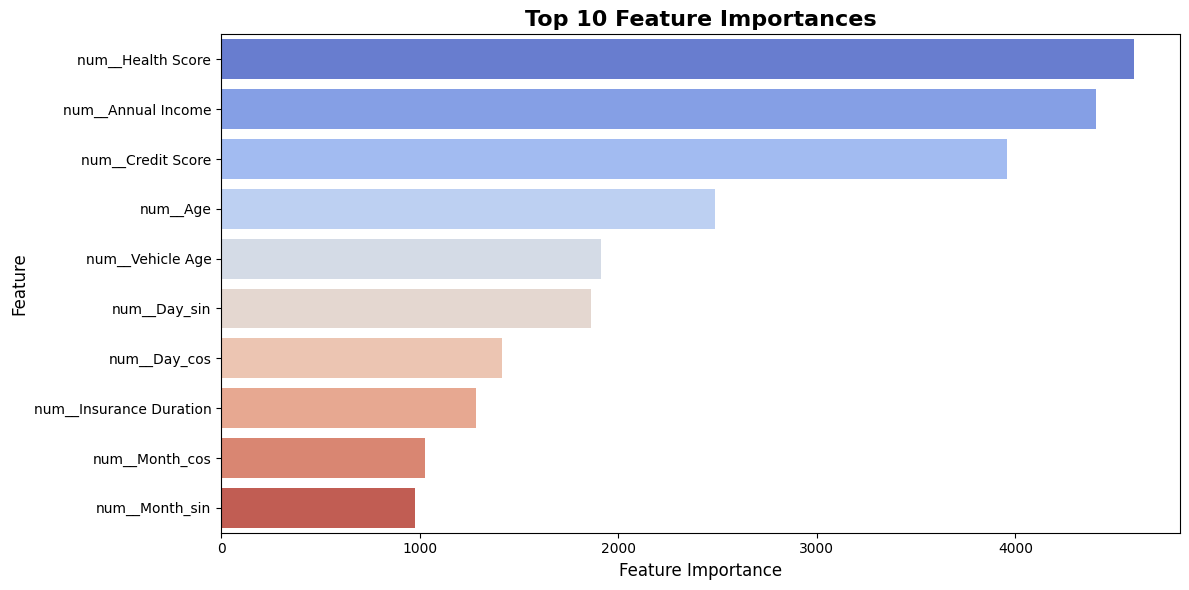

In [21]:
# Feature importance
importances = final_model.feature_importance(importance_type='split')  # or 'gain'
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm", hue = 'Feature')
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

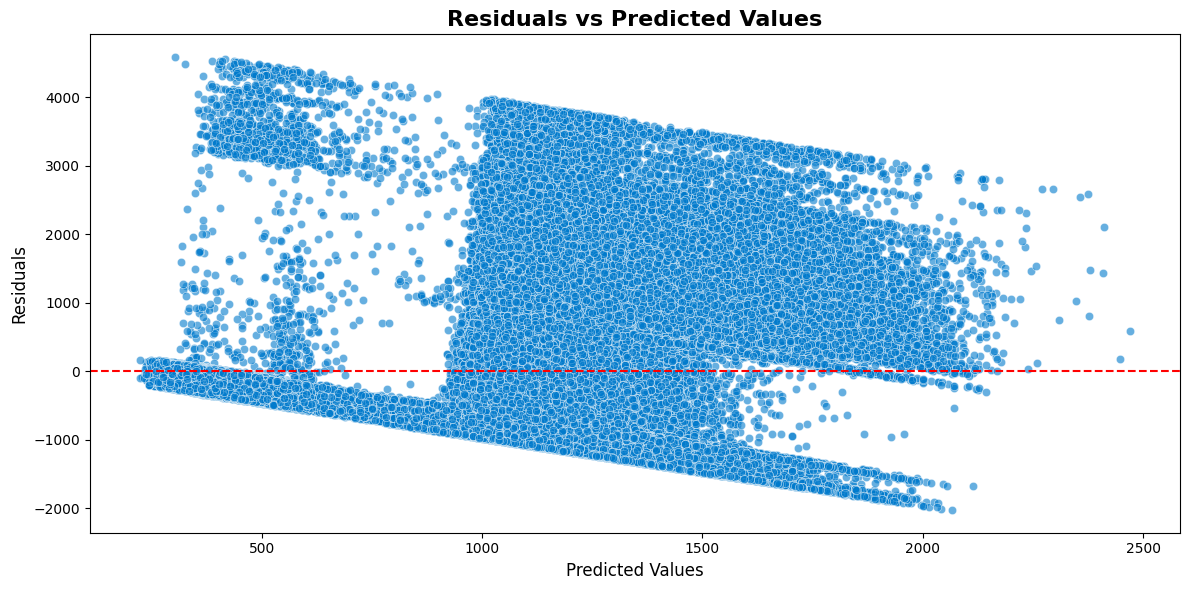

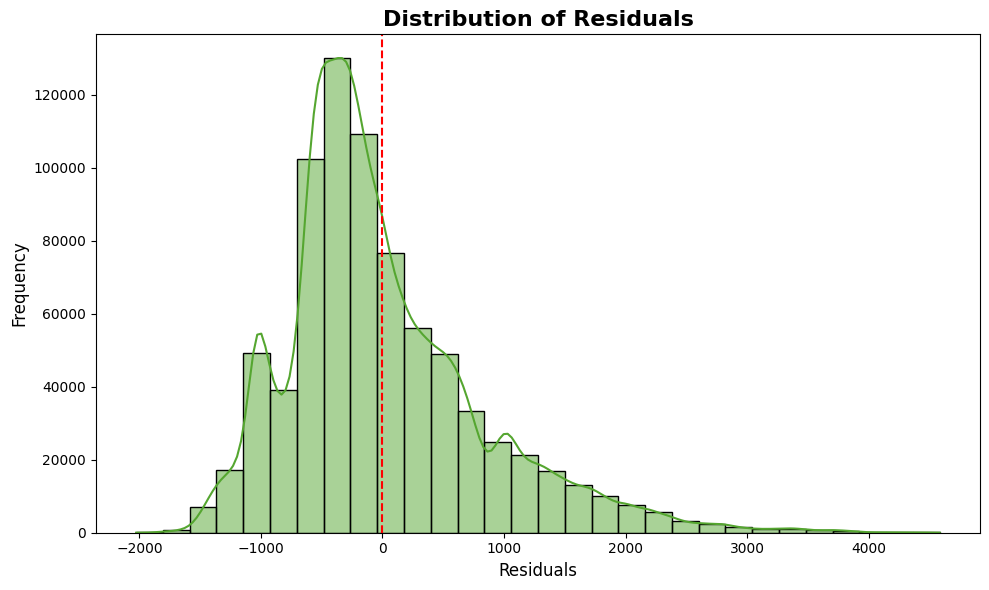

In [22]:
# Calculate Residuals
residuals = y - y_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()


Performance Metrics:
------------------------------
RMSLE: 1.1349
RMSE: 835.6963
MAE: 630.1971
R²: 0.0649


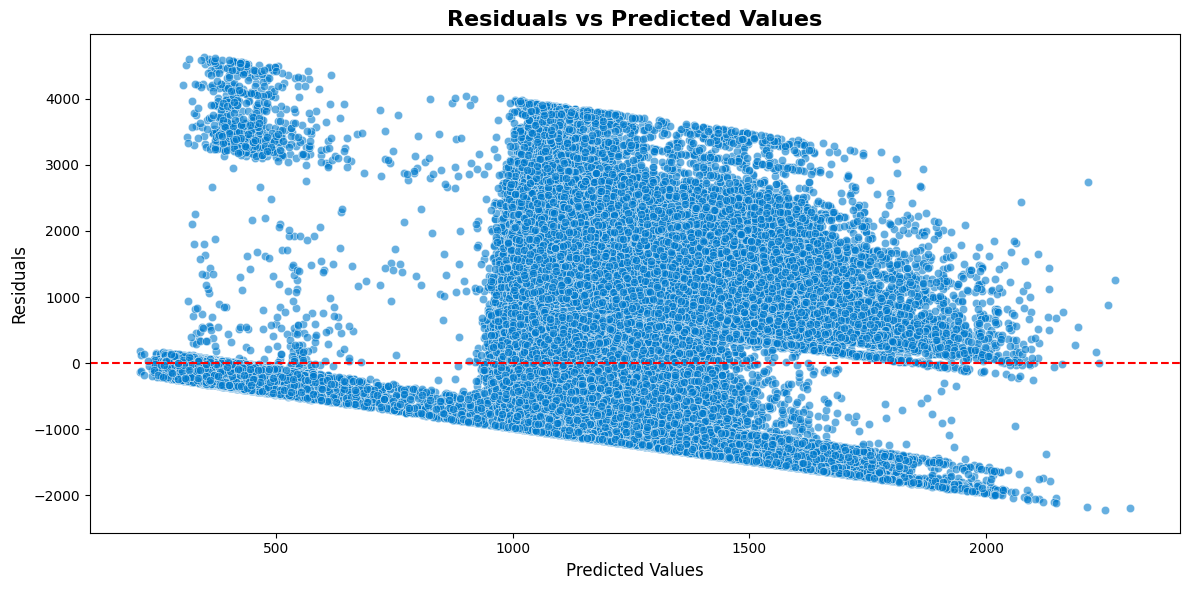

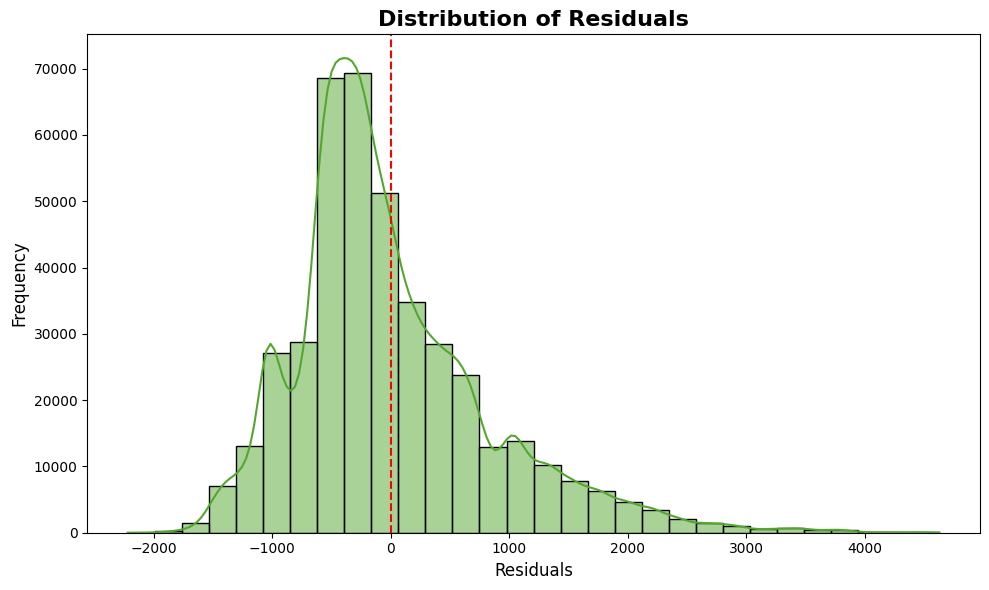

In [23]:
y_test_pred = final_model.predict(test_processed)

rmsle = root_mean_squared_log_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

test_residuals = y_test - y_test_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
joblib.dump(final_model, "models/lgb_fin_model.joblib")

['models/lgb_fin_model.joblib']

In [25]:
joblib.dump(preprocessor, 'models/preprocessor.joblib')

['models/preprocessor.joblib']

In [26]:
explainer = shap.TreeExplainer(final_model)

In [35]:
num_features_out = numerical_features

# Get categorical feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features_out = cat_encoder.get_feature_names_out(categorical_features)

# Combine
all_feature_names = list(num_features_out) + list(cat_features_out)


In [36]:
X_explainer = pd.DataFrame(X_processed, columns = all_feature_names)

In [37]:
shap_values = explainer(X_explainer)

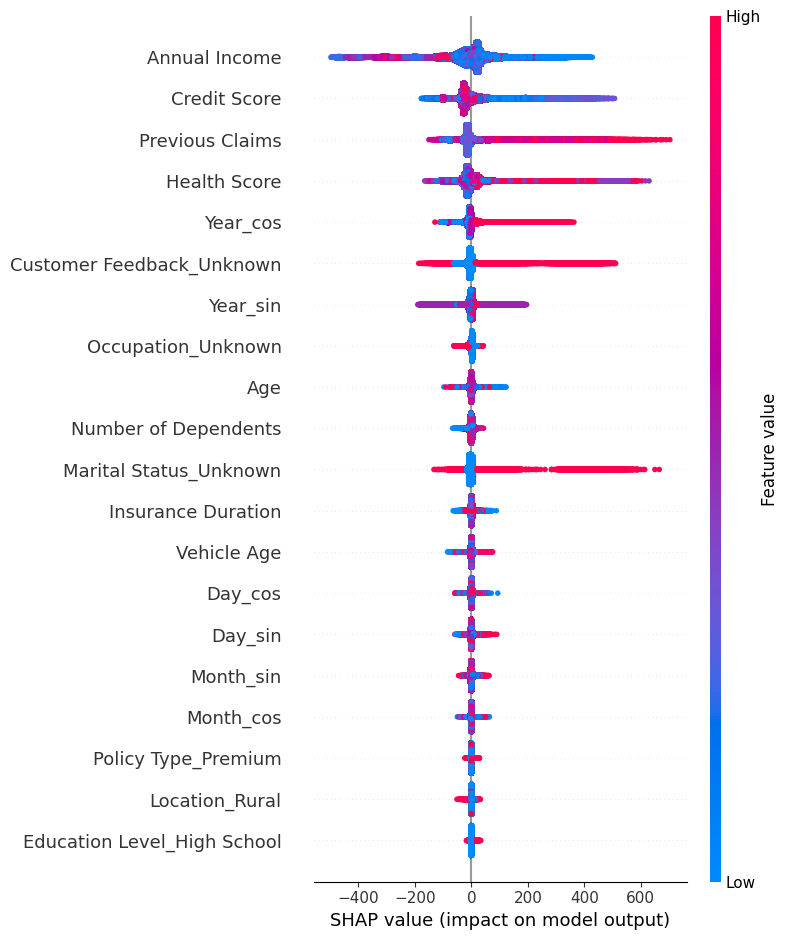

In [38]:
shap.summary_plot(shap_values, X_explainer)

In [39]:
joblib.dump(shap_values, "models/shap_values.joblib")

['models/shap_values.joblib']

In [40]:
joblib.dump(explainer, "models/shap_explainer.joblib")

['models/shap_explainer.joblib']